In [149]:
from glob import glob
import pint.models as model
# pip install git+https://github.com/telegraphic/pygdsm
# or install from source (git clone https://github.com/telegraphic/pygdsm)
import pygdsm
import os
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
from astropy import units as u, constants as c
from astropy.coordinates import SkyCoord, ICRS, Galactic
from scipy.optimize import curve_fit

In [81]:
def get_prof_nbin(fname):
    x,y,z,intensity = np.loadtxt(fname,unpack=True,dtype='float',skiprows=1)
    nbin = len(intensity)
    
    return intensity,nbin

def get_on_binwidth(folded_profile,threshold = 0.925,interpulse=False):
    
    box_size = []
    max_conv = []
    nbin = len(folded_profile)
    for jj in range(1,nbin):
        box = np.zeros(nbin)
        box_width = jj
        box_size.append(box_width)
        box[0:box_width] += 1.0
        conv = np.convolve(box,folded_profile)
        max_conv.append(np.max(conv))
    
    on_width = np.argmin((np.array(max_conv)-threshold)**2) + 1
    return on_width

def roll_prof(profile,max_phase=0.3):
    nbin = len(profile)
    max_ind = np.argmax(profile)
    shift = int(max_phase * nbin) - max_ind
    return np.roll(profile,shift)
    
def get_si(freq1,flux1,freq2,flux2):
    si = np.log10(flux2/flux1)/np.log10(freq2/freq1)
    return si

def powerlaw(x, a, b):
    return a*x**b

def get_si_multi(freqs,fluxes,flux_errs):
    pars, pcov = curve_fit(f=powerlaw, xdata=freqs, ydata=fluxes, sigma = flux_errs, p0=[0, 0], bounds = ([-np.inf, -5.],[np.inf,2.]))
    coeff  = pars[0]
    si     = pars[1]
    si_err = np.sqrt(np.diag(pcov))[1]
    return si, si_err, coeff

class OnOff:
    """
    This class contains the functionality to parse .onoff files;
    the corresponding object contains relevant information.
    """
    def __init__(self, filename):
        """
        Initialization method.

        Parses and stores header values, profile intensities, and on/off info.

        Parameters
        ==========
        filename (str) : path to the .onoff file
        """
        self.filename = filename
        
        with open(self.filename,'r') as f:
            onoff_contents = f.readlines()
            
        for line in onoff_contents:

            # Parse header to get relevant profile info
            if line.startswith("#"):
                for item in line.split():
                    if "tobs" in item:
                        self.tobs = float(item.split("=")[1].replace(",",""))
                    elif "snr" in item:
                        self.snr = float(item.split("=")[1].replace(",",""))
                    elif "duty" in item:
                        self.duty = float(item.split("=")[1].replace(",",""))
                    elif "degradation" in item:
                        self.deg = float(item.split("=")[1].replace(",",""))
                    elif "file" in item:
                        self.prof_file = item.split("=")[1]
                    else:
                        continue
            else:
                continue
            
        self.profile, self.onoff = np.loadtxt(self.filename,dtype='float',unpack=True)
        self.nbin = len(self.profile)
        self.wid = int(np.round(self.nbin * self.duty)) # (integer) box_width

In [74]:
"""Observation times (tobs) listed here come from `vap -c length` on the original
archives and degradation is based on position offset during observing. I
generated profiles for the most part only using scans where the position offset
caused < 10% degradation (deg=0.9), but in some cases that was not possible.

Degradation values (deg) come from work in data/profile_pos_check.ipynb, which was
used to find a suitable list of files to use, which in most cases, meant accepting
degradation in SNR up to 10% due to position offset. In some cases (e.g. J1122), a
coherent timing solution was not available until late in the follow-up campaign, so
including enough data to generate a decent profile meant also accepting a different
deg threshold. Note 10% degradation equates to deg = 0.9.
"""

datadir = "data/"

profsfreqstobs = np.loadtxt(f"{datadir}lengths.dat", skiprows=1, dtype=str)

prof57   = []
tobs57   = []
deg57    = []
prof327  = []
tobs327  = []
deg327   = []
prof350  = []
tobs350  = []
deg350   = []
prof430  = []
tobs430  = []
deg430   = []
prof820  = []
tobs820  = []
deg820   = []
prof1380 = []
tobs1380 = []
deg1380  = []
prof1500 = []
tobs1500 = []
deg1500  = []
prof2000 = []
tobs2000 = []
deg2000  = []

for pft in profsfreqstobs:
    fnamebase = pft[0][:-6]
    psr, freq = fnamebase.split("_")
    tobs      = float(pft[1])
    prof      = f"{datadir}{fnamebase}MHz_fiore+22.profile"
    if freq == "57.15":
        prof57 = np.append(prof57, prof)
        tobs57 = np.append(tobs57, tobs)
        deg57  = np.append(deg57, 0.9)
    elif freq == "327":
        prof327 = np.append(prof327, prof)
        tobs327 = np.append(tobs327, tobs)
        deg327  = np.append(deg327, 0.9)
    elif freq == "350":
        prof350 = np.append(prof350, prof)
        tobs350 = np.append(tobs350, tobs)
        if psr == "J0415+6111":
            deg = 0.77
        elif psr == "J1505-2524":
            deg = 0.6
        elif psr == "J1530-2114":
            deg = 0.8
        elif psr == "J1913+3732":
            deg = 0.1
        elif psr == "J1929+6630":
            deg = 0.3
        elif psr == "J1930+6205":
            deg = 0.6
        elif psr == "J2104+2830":
            deg = 0.3
        elif psr == "J2115+6702":
            deg = 0.85
        elif psr == "J2145+2158":
            deg = 0.59
        else:
            deg = 0.9
        deg350  = np.append(deg350, deg)
    elif freq == "430":
        prof430 = np.append(prof430, prof)
        tobs430 = np.append(tobs430, tobs)
        deg430  = np.append(deg430, 0.9)
    elif freq == "820":
        prof820 = np.append(prof820, prof)
        tobs820 = np.append(tobs820, tobs)
        if psr == "J0141+6303":
            deg = 0.5
        elif psr == "J0415+6111":
            deg = 0.75
        elif psr == "J1530-2114":
            deg = 0.7
        elif psr == "J1913+3732":
            deg = 0.1
        elif psr == "J1929+6630":
            deg = 0.8
        elif psr == "J1930+6205":
            deg = 0.75
        elif psr == "J2104+2830":
            deg = 0.75
        elif psr == "J2210+5712":
            deg = 0.8
        else: deg = 0.9
        deg820  = np.append(deg820, deg)
    elif freq == "1380":
        prof1380 = np.append(prof1380, prof)
        tobs1380 = np.append(tobs1380, tobs)
        deg1380  = np.append(deg1380, 0.9)
    elif freq == "1500":
        prof1500 = np.append(prof1500, prof)
        tobs1500 = np.append(tobs1500, tobs)
        deg1500  = np.append(deg1500, 0.9)
    elif freq == "2000":
        prof2000 = np.append(prof2000, prof)
        tobs2000 = np.append(tobs2000, tobs)
        deg2000  = np.append(deg2000, 0.9)
    else:
        print(f"This is a weird frequency: {freq}")
        break

#print(f"Number of 350/820 profiles: {len(prof350)}/{len(prof820)}")

In [75]:
def onoff(OBSERVING_FREQ, index, OVERWRITE_ONOFF=False, box_width=None):
    """The convolution makes boxes match profiles better for plotting, but
    this is an iterative/by-eye process of finding box widths that match
    the full width of the on-pulse. Change index/box_width until the plot looks 
    good and a .onoff file will be written with useful info in the header and 1/0
    denoting bins where the pulsar signal is on/off. Note that setting the
    OVERWRITE_ONOFF variable to False makes this cell read from an existing
    file and display the profiles/box/values recorded there.

    To iterate from existing work, run the cell to get a sense for box_width, set
    that variable accordingly, turn on OVERWRITE_ONOFF, then iterate and tweak the
    box_width as necessary. Finally turn off OVERWRITE_ONOFF and check results with
    a final run."""

    if OBSERVING_FREQ == 57.15:
        tobs = tobs57[index]
        ff = prof57[index]
        degradation = deg57[index]
    elif OBSERVING_FREQ == 327:
        tobs = tobs327[index]
        ff = prof327[index]
        degradation = deg327[index]    
    elif OBSERVING_FREQ == 350:
        tobs = tobs350[index]
        ff = prof350[index]
        degradation = deg350[index]
    elif OBSERVING_FREQ == 430:
        tobs = tobs430[index]
        ff = prof430[index]
        degradation = deg430[index]
    elif OBSERVING_FREQ == 820:
        tobs = tobs820[index]
        ff = prof820[index]
        degradation = deg820[index]
    elif OBSERVING_FREQ == 1380:
        tobs = tobs1380[index]
        ff = prof1380[index]
        degradation = deg1380[index]
    elif OBSERVING_FREQ == 1500:
        tobs = tobs1500[index]
        ff = prof1500[index]
        degradation = deg1500[index]
    elif OBSERVING_FREQ == 2000:
        tobs = tobs2000[index]
        ff = prof2000[index]
        degradation = deg2000[index]

    # check if .onoff file already exists, use it 
    of = ff.replace('profile','onoff')
    if os.path.exists(of):
        print(f" ON/OFF file exists: {of}")
        oo_obj = OnOff(of)
        print(f"Width (from .onoff): {oo_obj.wid}")
        print(f"Degr. (from .onoff): {oo_obj.deg}")
        print(f"  SNR (from .onoff): {oo_obj.snr}")
        profile, on_window, nbin = oo_obj.profile, oo_obj.onoff, oo_obj.nbin
        on_window *= np.max(profile)
        print()

    if OVERWRITE_ONOFF:
        print(f"File: {ff}")
        prof,nbin = get_prof_nbin(ff)
        normed_prof = prof/np.sum(prof)
        profile = roll_prof(normed_prof,max_phase=0.5)

        box = np.zeros(nbin)
        box[0:box_width] += max(profile)

        if ('J1816' in ff) and ('350MHz' in ff):
            box[75:95] += 0.3*max(profile) # Add for J1816, 350 MHz
        elif ('J1816' in ff) and ('820MHz' in ff):
            box[75:95] += 0.15*max(profile) # Add for J1816, 820 MHz
        elif ('J0214' in ff) and ('820MHz' in ff):
            box[83:116] += 0.1*max(profile) # Add for J0214, 820 MHz
        elif ('J1434' in ff) and ('350MHz' in ff):
            box[62:70] += 0.1*max(profile) # Add for J1434, 350 MHz
        elif ('J1434' in ff) and ('820MHz' in ff):
            box[62:74] += 0.22*max(profile) # Add for J1434, 820 MHz
        elif ('J1434' in ff) and ('1500MHz' in ff):
            box[60:68] += 0.36*max(profile) # Add for J1434, 1500 MHz
        conv = np.convolve(box,profile)
        conv_box = np.roll(box,nbin-box_width)
        on_window = np.roll(conv_box,np.argmax(conv))
        off_inds = np.where(on_window == 0.0)

        box_width = len(np.where(box != 0.0)[0])
        print(f"Width: {box_width}")

        # Calculate S/N
        off_mean = np.mean(profile[off_inds])
        off_std = np.std(profile[off_inds])
        snr = np.sum((profile-off_mean)/(off_std*np.sqrt(box_width)))
        print(f"SNR: {snr}")

    plt.plot(on_window)
    plt.plot(profile)
    plt.plot(np.zeros(nbin)+0.1*np.max(profile),ls='--',color='gray')

    # WRITE ROLLED PROFILE + CORRESPONDING ON/OFF INFO TO FILE (.onoff)
    if OVERWRITE_ONOFF:
        onoff = [np.ceil(x) for x in on_window]
        with open(of,'w') as f:
            file_only = ff.split("/")[1]
            duty=box_width/nbin
            #write header
            f.write(f"# file={file_only} \n")
            f.write(f"# tobs={tobs}, snr={snr:.5f}, duty={duty:.5f}, degradation={degradation} \n")
            for pp,oo in zip(profile,onoff):
                f.write(f"{pp:.8f} {oo}\n")

 ON/OFF file exists: data/J1327+3423_57.15MHz_fiore+22.onoff
Width (from .onoff): 17
Degr. (from .onoff): 0.9
  SNR (from .onoff): 107.32829



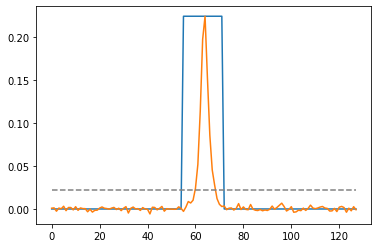

In [76]:
onoff(57.15, 0, OVERWRITE_ONOFF=False, box_width=25)

In [157]:
gsm = pygdsm.GlobalSkyModel()

beta = 1.3
Gain = 2.0
Npol = 2

FluxDict = {}
par_paths = np.sort(glob("data/*fiore+22.par"))
for pp in par_paths:
    with open(pp, 'r') as infile:
        for l in infile.readlines():
            if l.startswith("PSRJ"):
                psr = l.split()[1]
            elif l.startswith("RAJ"):
                ra_str = l.split()[1]
            elif l.startswith("DECJ"):
                dec_str = l.split()[1].strip("+")
            else:
                pass
    onoffs = np.sort(glob(f"data/{psr}*.onoff")) # .onoff files associated with given par
    eqcoord = SkyCoord(ra_str,dec_str,frame=ICRS,unit=(u.hourangle, u.deg))
    gcoord = eqcoord.transform_to(Galactic)
    [Tsky57,Tsky327,Tsky350,Tsky430,Tsky820,Tsky1380,Tsky1500,Tsky2000] = gsm.get_sky_temperature(gcoord, freqs=np.array([57.15,327.0,350.0,430.0,820.0,1380.0,1500.0,2000.0])) # Includes Tcmb

    psrDict = {
        'Flux57':None,
        'errFlux57':None,
        'Flux327':None,
        'errFlux327':None,
        'Flux350':None,
        'errFlux350':None,
        'Flux430':None,
        'errFlux430':None,
        'Flux820':None,
        'errFlux820':None,
        'Flux1380':None,
        'errFlux1380':None,
        'Flux1500':None,
        'errFlux1500':None,
        'Flux2000':None,
        'errFlux2000':None,
        'SI':None,
        'errSI':None,
        'Tobs57':None,
        'Tobs327':None,
        'Tobs350':None,
        'Tobs430':None,
        'Tobs820':None,
        'Tobs1380':None,
        'Tobs1500':None,
        'Tobs2000':None,
              }
    
    for oo_file in onoffs:
        
        ooo = OnOff(oo_file)
        
        # Get frequency-dependent info
        if "57.15MHz" in oo_file:
            bw = 78.4*0.75 # 25 pct reduction (RFI) Overlapping bands (true bandwidth ~ 60 MHz)
            Tsys = Tsky57+250.0 # Uncertainty?
            flux_key = 'Flux57'
            psrDict['Tobs57'] = ooo.tobs
            psrDict['Duty57'] = ooo.duty
        elif "327MHz" in oo_file:   #only one AO327 observation of J1327, which scintillates strongly
            bw = 87.5
            Tsys = Tsky327+75.0 # Uncertainty?
            flux_key = 'Flux327'
            psrDict['Tobs327'] = ooo.tobs
            psrDict['Duty327'] = ooo.duty
        elif "350MHz" in oo_file:
            bw = 70 # 30 pct reduction (RFI) (wasn't this bad prior to 2014-ish)
            Tsys = Tsky350+23.0 # Uncertainty?
            flux_key = 'Flux350'
            psrDict['Tobs350'] = ooo.tobs
            psrDict['Duty350'] = ooo.duty
        elif "430MHz" in oo_file:
            bw = 100 
            Tsys = Tsky430+35.0 # Uncertainty?
            flux_key = 'Flux430'
            psrDict['Tobs430'] = ooo.tobs
            psrDict['Duty430'] = ooo.duty
        elif "820MHz" in oo_file:
            bw = 175 # 12.5 pct reduction (RFI)
            Tsys = Tsky820+22.0
            flux_key = 'Flux820'
            psrDict['Tobs820'] = ooo.tobs
            psrDict['Duty820'] = ooo.duty
        elif "1380MHz" in oo_file:
            bw = 800*0.75 # 25 pct reduction (RFI)
            Tsys = Tsky1380+25.0
            flux_key = 'Flux1380'
            psrDict['Tobs1380'] = ooo.tobs
            psrDict['Duty1380'] = ooo.duty
        elif "1500MHz" in oo_file:
            bw = 800*0.92 # 8 pct reduction (RFI)
            Tsys = Tsky1500+18.0
            flux_key = 'Flux1500'
            psrDict['Tobs1500'] = ooo.tobs
            psrDict['Duty1500'] = ooo.duty
        elif "2000MHz" in oo_file:
            bw = 800*0.9 # 10 pct reduction (RFI)
            Tsys = Tsky2000+20.0
            flux_key = 'Flux2000'
            psrDict['Tobs2000'] = ooo.tobs
            psrDict['Duty2000'] = ooo.duty
            
        flux = beta*ooo.snr*Tsys*np.sqrt(ooo.duty/(1-ooo.duty))/(Gain*np.sqrt(Npol*ooo.tobs*bw))/ooo.deg
        
        # Main contributors to uncertainty = Tsys (5 K), degradation (factor due to offset, 5-30%), bw (10 MHz?)
        deg_err = (1.0-ooo.deg)/2.0
        flux_err = flux*np.sqrt((deg_err/ooo.deg)**2+(5.0/Tsys)**2+0.5*(10.0/bw)**2)
        psrDict[flux_key] = flux
        psrDict[f"err{flux_key}"] = flux_err
        
        #print(f"{oo_file}: {flux:.3f}+/-{flux_err:.3f} mJy")
        #print(flux_key)
    
    # Calculate spectral indices (and error!)
    all_fluxes  = [psrDict['Flux57'],psrDict['Flux350'],psrDict['Flux430'],psrDict['Flux820'],psrDict['Flux1380'],psrDict['Flux1500'],psrDict['Flux2000']]
    flux_exists = [S is not None for S in all_fluxes]
    fluxes      = np.array(all_fluxes)[flux_exists]
    freqs       = np.array([57.15, 350.0, 430.0, 820.0, 1380.0, 1500.0, 2000.0])[flux_exists]
    flux_errs   = np.array([psrDict['errFlux57'],psrDict['errFlux350'],psrDict['errFlux430'],psrDict['errFlux820'],psrDict['errFlux1380'],psrDict['errFlux1500'],psrDict['errFlux2000']])[flux_exists]
    if len(fluxes) == 2:
        si = get_si(freqs[0], fluxes[0], freqs[1], fluxes[1])
        psrDict['SI'] = si
        a = np.abs(1.0/(np.log10(fluxes[1]/fluxes[0])*np.log(10.0)))
        coeff = np.exp(0.5*(np.log(fluxes[0]*fluxes[1])-np.log(fluxes[1]/fluxes[0])*np.log(freqs[0]*freqs[1])/np.log(freqs[1]/freqs[0])))
        psrDict['coeff'] = coeff
        si_err = a*np.sqrt((flux_errs[0]/fluxes[0])**2+(flux_errs[1]/fluxes[1])**2)
        psrDict['errSI'] = si_err
        print(f"Spectral index for {psr}: {si:.2f} +/- {si_err:.2f}")
    elif len(fluxes) > 2:
        si, si_err, coeff = get_si_multi(freqs, fluxes, list(flux_errs))
        psrDict['SI'] = si
        psrDict['errSI'] = si_err
        psrDict['coeff'] = coeff
        print(f"Spectral index for {psr}: {si:.2f} +/- {si_err:.2f}")
    else:
        print(f"{psr} does not have enough info to calculate spectral index.")
        
    if si_err > np.abs(si):
        print(f"Spectral index is not well constrained for {psr}.")
        
    FluxDict[psr] = psrDict

Spectral index for J0032+6946: 0.06 +/- 3.92
Spectral index is not well constrained for J0032+6946.
Spectral index for J0141+6303: -0.87 +/- 0.73
Spectral index for J0214+5222: 0.07 +/- 3.63
Spectral index is not well constrained for J0214+5222.
Spectral index for J0415+6111: -1.84 +/- 0.19
Spectral index for J0636+5128: -1.66 +/- 0.41
J0957-0619 does not have enough info to calculate spectral index.
Spectral index for J1239+3239: -0.04 +/- 6.95
Spectral index is not well constrained for J1239+3239.
Spectral index for J1327+3423: -0.77 +/- 0.16
Spectral index for J1434+7257: -1.50 +/- 0.22
Spectral index for J1505-2524: -1.62 +/- 0.29
Spectral index for J1530-2114: -1.35 +/- 0.29
Spectral index for J1816+4510: -2.95 +/- 0.50
Spectral index for J1913+3732: -2.01 +/- 3.71
Spectral index is not well constrained for J1913+3732.
Spectral index for J1929+6630: -2.72 +/- 0.52
Spectral index for J1930+6205: -2.25 +/- 0.23
Spectral index for J2104+2830: -2.85 +/- 0.49
Spectral index for J2115+6

In [158]:
import table_utils as tu

# WRITE TABLE LINES

psrs_more_freq = ["J0636+5128", "J1434+7257", "J1816+4510"]

for psr in FluxDict.keys():
    pD = FluxDict[psr]
    if psr in psrs_more_freq or psr=="J1327+3423":
        continue
    if pD['Flux350']:
        S350_tex = tu.ufve(pD['Flux350'],pD['errFlux350'],digits=tu.digits_for_unc(pD['errFlux350']))
        tobs350str = f"{pD['Tobs350']:.1f}"
        duty350str = f"{pD['Duty350']:.2f}"
    else:
        S350_tex = "--"
        tobs350str = "--"
        duty350str = "--"
    if pD['Flux820']:
        S820_tex = tu.ufve(pD['Flux820'],pD['errFlux820'],digits=tu.digits_for_unc(pD['errFlux820']))
        tobs820str = f"{pD['Tobs820']:.1f}"
        duty820str = f"{pD['Duty820']:.2f}"
    if pD['SI'] is not None:
        SI_tex = tu.ufve(pD['SI'],pD['errSI'],digits=tu.digits_for_unc(pD['errSI']))
    else:
        SI_tex = "--"

    tex_line = f"{psr} & {tobs350str} & {duty350str} & {S350_tex} & & " + \
               f"{tobs820str} & {duty820str} & {S820_tex} & {SI_tex} \\\\"
    print(tex_line.replace("-","$-$").replace("$-$$-$","--"))
    
for psr in psrs_more_freq:
    pD = FluxDict[psr]
    if pD['Flux350']:
        S350_tex = tu.ufve(pD['Flux350'],pD['errFlux350'],digits=tu.digits_for_unc(pD['errFlux350']))
        tobs350str = f"{pD['Tobs350']:.1f}"
        duty350str = f"{pD['Duty350']:.2f}"
    else:
        S350_tex = "--"
        tobs350str = "--"
        duty350str = "--"
    if pD['Flux820']:
        S820_tex = tu.ufve(pD['Flux820'],pD['errFlux820'],digits=tu.digits_for_unc(pD['errFlux820']))
        tobs820str = f"{pD['Tobs820']:.1f}"
        duty820str = f"{pD['Duty820']:.2f}"
    if pD['Flux1500']:
        S1500_tex = tu.ufve(pD['Flux1500'],pD['errFlux1500'],digits=tu.digits_for_unc(pD['errFlux1500']))
        tobs1500str = f"{pD['Tobs1500']:.1f}"
        duty1500str = f"{pD['Duty1500']:.2f}"
    else:
        S1500_tex = "--"
        tobs1500str = "--"
        duty1500str = "--"
    if pD['Flux2000']:
        S2000_tex = tu.ufve(pD['Flux2000'],pD['errFlux2000'],digits=tu.digits_for_unc(pD['errFlux2000']))
        tobs2000str = f"{pD['Tobs2000']:.1f}"
        duty2000str = f"{pD['Duty2000']:.2f}"
    else:
        S2000_tex = "--"
        tobs2000str = "--"
        duty2000str = "--"
    if pD['SI'] is not None:
        SI_tex = tu.ufve(pD['SI'],pD['errSI'],digits=tu.digits_for_unc(pD['errSI']))
    else:
        SI_tex = "--"

    tex_line = f"{psr} & {tobs350str} & {duty350str} & {S350_tex} & & " + \
               f"{tobs820str} & {duty820str} & {S820_tex} & & " + \
               f"{tobs1500str} & {duty1500str} & {S1500_tex} & & " + \
               f"{tobs2000str} & {duty2000str} & {S2000_tex} & {SI_tex} \\\\"
    print(tex_line.replace("-","$-$").replace("$-$$-$","--"))
    
psr = "J1327+3423"
pD = FluxDict[psr]
S57_tex = tu.ufve(pD['Flux57'],pD['errFlux57'],digits=tu.digits_for_unc(pD['errFlux57']))
tobs57str = f"{pD['Tobs57']:.1f}"
duty57str = f"{pD['Duty57']:.2f}"

S327_tex = tu.ufve(pD['Flux327'],pD['errFlux327'],digits=tu.digits_for_unc(pD['errFlux327']))
tobs327str = f"{pD['Tobs327']:.1f}"
duty327str = f"{pD['Duty327']:.2f}"

S350_tex = tu.ufve(pD['Flux350'],pD['errFlux350'],digits=tu.digits_for_unc(pD['errFlux350']))
tobs350str = f"{pD['Tobs350']:.1f}"
duty350str = f"{pD['Duty350']:.2f}"

S430_tex = tu.ufve(pD['Flux430'],pD['errFlux430'],digits=tu.digits_for_unc(pD['errFlux430']))
tobs430str = f"{pD['Tobs430']:.1f}"
duty430str = f"{pD['Duty430']:.2f}"

S820_tex = tu.ufve(pD['Flux820'],pD['errFlux820'],digits=tu.digits_for_unc(pD['errFlux820']))
tobs820str = f"{pD['Tobs820']:.1f}"
duty820str = f"{pD['Duty820']:.2f}"

S1380_tex = tu.ufve(pD['Flux1380'],pD['errFlux1380'],digits=tu.digits_for_unc(pD['errFlux1380']))
tobs1380str = f"{pD['Tobs1380']:.1f}"
duty1380str = f"{pD['Duty1380']:.2f}"

SI_tex = tu.ufve(pD['SI'],pD['errSI'],digits=tu.digits_for_unc(pD['errSI']))

tex_line = f"{psr} & {tobs57str} & {duty57str} & {S57_tex} & & " + \
           f"{tobs327str} & {duty327str} & {S327_tex} & & " + \
           f"{tobs350str} & {duty350str} & {S350_tex} & & " + \
           f"{tobs430str} & {duty430str} & {S430_tex} & & " + \
           f"{tobs820str} & {duty820str} & {S820_tex} & & " + \
           f"{tobs1380str} & {duty1380str} & {S1380_tex} & {SI_tex} \\\\"
print(tex_line.replace("-","$-$").replace("$-$$-$","--"))

J0032+6946 & 3925.9 & 0.09 & 0.60(8) & & 3856.8 & 0.09 & 0.63(11) & 0(4) \\
J0141+6303 & 7241.0 & 0.12 & 0.96(12) & & 10089.5 & 0.09 & 0.5(2) & $-$0.9(7) \\
J0214+5222 & 4890.4 & 0.10 & 1.19(16) & & 14395.7 & 0.65 & 1.3(2) & 0(4) \\
J0415+6111 & 111.4 & 0.08 & 1.7(3) & & 5428.9 & 0.09 & 0.36(9) & $-$1.84(19) \\
J0957$-$0619 & -- & -- & -- & & 8750.2 & 0.10 & 0.19(4) & -- \\
J1239+3239 & 11963.6 & 0.47 & 2.2(3) & & 13179.1 & 0.69 & 2.1(4) & $-$0(7) \\
J1505$-$2524 & 111.4 & 0.05 & 2.6(9) & & 6173.7 & 0.05 & 0.66(12) & $-$1.6(3) \\
J1530$-$2114 & 1774.4 & 0.04 & 0.65(12) & & 7945.9 & 0.05 & 0.21(6) & $-$1.3(3) \\
J1913+3732 & 334.2 & 0.04 & 2(8) \times 10^{1} & & 6254.4 & 0.05 & 3(15) & $-$2(4) \\
J1929+6630 & 636.9 & 0.09 & 2(2) & & 2920.9 & 0.05 & 0.17(4) & $-$2.7(5) \\
J1930+6205 & 605.3 & 0.04 & 0.9(3) & & 4613.1 & 0.05 & 0.13(3) & $-$2.3(2) \\
J2104+2830 & 344.3 & 0.06 & 2(3) & & 2044.6 & 0.03 & 0.22(5) & $-$2.8(5) \\
J2115+6702 & 111.4 & 0.05 & 0.86(13) & & 6193.3 & 0.08 & 0.13(2) 

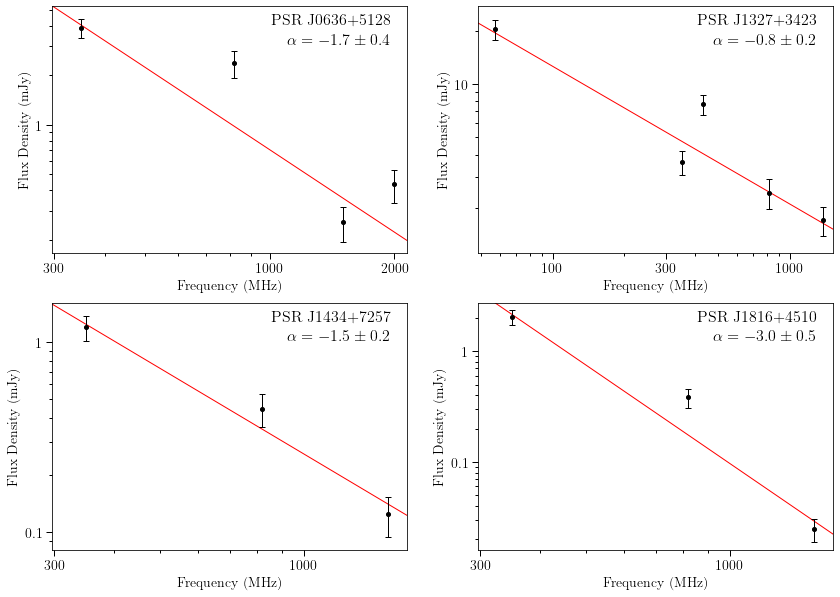

In [214]:
import matplotlib as mpl
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
fig_width = 4.0
fig_height = 5.0  #fig_width*0.6
fig_size = [fig_width,fig_height]
params = {'backend': 'pdf',
          'font.size'      : 30*fig_width/8.5,
          'axes.labelsize' : 30*fig_width/8.5,
          'xtick.labelsize': 30*fig_width/8.5,
          'ytick.labelsize': 30*fig_width/8.5,
          'text.usetex'    : True,
          'figure.figsize' : fig_size,
          'axes.unicode_minus': True}
mpl.rcParams.update(params)
plt.figure(figsize=(14, 10))
#plt.subplots_adjust(hspace=0.5)
n=0
for psr in FluxDict.keys():
    pD = FluxDict[psr]
    freqs     = []
    fluxes    = []
    flux_errs = []
    if pD['Flux57']:
        freqs.append(57.15)
        fluxes.append(pD['Flux57'])
        flux_errs.append(pD['errFlux57'])
#     if pD['Flux327']:
#         freqs.append(327.0)
#         fluxes.append(pD['Flux327'])
#         flux_errs.append(pD['errFlux327'])
    if pD['Flux350']:
        freqs.append(350.0)
        fluxes.append(pD['Flux350'])
        flux_errs.append(pD['errFlux350'])
    if pD['Flux430']:
        freqs.append(430.0)
        fluxes.append(pD['Flux430'])
        flux_errs.append(pD['errFlux430'])
    if pD['Flux820']:
        freqs.append(820.0)
        fluxes.append(pD['Flux820'])
        flux_errs.append(pD['errFlux820'])
    if pD['Flux1380']:
        freqs.append(1380.0)
        fluxes.append(pD['Flux1380'])
        flux_errs.append(pD['errFlux1380'])
    if pD['Flux1500']:
        freqs.append(1500.0)
        fluxes.append(pD['Flux1500'])
        flux_errs.append(pD['errFlux1500'])
    if pD['Flux2000']:
        freqs.append(2000.0)
        fluxes.append(pD['Flux2000'])
        flux_errs.append(pD['errFlux2000'])
    if len(fluxes) > 2:
        n+=1
        SI     = pD['SI']
        SI_err = pD['errSI']
        SI_tex = tu.ufve(SI,SI_err)
        coeff  = pD['coeff']
        freq_i = min(freqs)*0.85
        freq_f = max(freqs)+150.0
        #n = (freq_f-freq_i)/0.1
        fs = np.arange(freq_i,freq_f,0.1)
        power_law = powerlaw(fs,coeff,SI)
        ax = plt.subplot(2,2,n)
        ax.plot(fs,power_law,c='r',linestyle='-',linewidth=1)
        ax.errorbar(freqs,fluxes,yerr=flux_errs,fmt='o',ms=4,capsize=3,elinewidth=1,c='black')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.text(0.95,0.94,f"PSR {psr}",color='black',rotation=0,size=16,va='center',ha='right',transform=ax.transAxes)
        ax.text(0.95,0.87,f"$\\alpha = {SI_tex.split('(')[0]}\\pm0.{SI_tex.strip(')').split('(')[1]}$",color='black',rotation=0,size=16,va='center',ha='right',transform=ax.transAxes)
        ax.xaxis.set_minor_formatter(plt.NullFormatter())
        ax.set_xticks([100.,300.,1000.,2000.])
        ax.set_xticklabels(["100","300","1000","2000"],fontsize=14)
        ax.set_yticks([0.1,1.,10.])
        ax.set_yticklabels(["0.1","1","10"],fontsize=14)
        ax.set_xlim([freq_i,freq_f])
        ax.set_ylim([0.65*min(fluxes),1.35*max(fluxes)])
        ax.tick_params(length=6,width=1,which='major')
        ax.tick_params(length=3,width=1,which='minor')
        ax.set_xlabel("Frequency (MHz)")
        ax.set_ylabel("Flux Density (mJy)")
plt.savefig("spectra.pdf",format='pdf',bbox_inches='tight',pad_inches=0.25)

In [160]:
# WRITE FILE WITH FLUX INFO FOR PLOTTING PROFILES

with open('data/flux.info','w') as f:
    f.write("# name s57 s327 s350 s430 s820 s1380 s1500 s2000 \n")
    for psr in FluxDict.keys():
        pD = FluxDict[psr]
        if pD['Flux57']:
            s57 = f"{pD['Flux57']:.2f}"
        else:
            s57 = "--"
        if pD['Flux327']:
            s327 = f"{pD['Flux327']:.2f}"
        else:
            s327 = "--"
        if pD['Flux350']:
            s350 = f"{pD['Flux350']:.2f}"
        else:
            s350 = "--"
        if pD['Flux430']:
            s430 = f"{pD['Flux430']:.2f}"
        else:
            s430 = "--"
        if pD['Flux820']:
            s820 = f"{pD['Flux820']:.2f}"
        else:
            s820 = "--"
        if pD['Flux1380']:
            s1380 = f"{pD['Flux1380']:.2f}"
        else:
            s1380 = "--"
        if pD['Flux1500']:
            s1500 = f"{pD['Flux1500']:.2f}"
        else:
            s1500 = "--"
        if pD['Flux2000']:
            s2000 = f"{pD['Flux2000']:.2f}"
        else:
            s2000 = "--"
        info_line = f"{psr} {s57} {s327} {s350} {s430} {s820} {s1380} {s1500} {s2000} \n"
        f.write(info_line)